### Importing required libraries

In [1]:
# import 'Numpy'
import numpy as np

# import 'Pandas' 
import pandas as pd

# import subpackage of Matplotlib
import matplotlib.pyplot as plt

# import color package from matplotlib
from matplotlib.colors import ListedColormap

# import 'Seaborn'
import seaborn as sns

# import datetime
import datetime

# to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

# import regular expression
import re

# import ast
import ast

# display all columns of the dataframe
pd.options.display.max_columns = None

# import train-test split
from sklearn.model_selection import train_test_split

# import Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# import various functions from sklearn
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,classification_report,confusion_matrix,f1_score
from sklearn.metrics import precision_score,recall_score

# import Logistic Regression
from sklearn.linear_model import LogisticRegression

# import DecisionTree Classifier
from sklearn.tree import DecisionTreeClassifier

# import RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier

#import Naivebayes
from sklearn.naive_bayes import MultinomialNB

# import XtremeGradientBoost Classifier
from xgboost import XGBClassifier

# import NeuralNetwork
from sklearn.neural_network import MLPClassifier

# import svm
from sklearn.svm import SVC

#import xgboost
from xgboost import XGBClassifier

# import wordlcoud, stopwords
from wordcloud import WordCloud,STOPWORDS

#import nltk
import nltk
from nltk.corpus import stopwords

In [2]:
# Reading the dataset and viewing the first 5 rows of it

train = pd.read_csv('twitter_training.csv' , header = None)
test = pd.read_csv('twitter_validation.csv', header = None)

df = pd.concat([train , test] , ignore_index=True )

df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
# Renaming the columns

df.rename(columns = {0:'Id',1:'Platform',2:'Sentiment',3:'Review'} , inplace = True)

In [4]:
df.head()

,Id,Platform,Sentiment,Review
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
# Dropping of id and platform

df.drop(columns = ['Id','Platform'] , inplace = True)

In [6]:
# Checking for missing values

df.isnull().sum()

Sentiment      0
Review       686
dtype: int64

In [7]:
# Dropping of null values

df.dropna(subset = 'Review' , inplace = True)

In [8]:
df.isnull().sum()

Sentiment    0
Review       0
dtype: int64

In [9]:
# Converting string into lower case characters

df['Review'] = df['Review'].apply(lambda x : str(x).lower())

In [10]:
# Removing special characters (Numbers , Punctuations , Characters)

df['Review'] = df['Review'].apply(lambda x : re.sub('[^a-z]+',' ',x))

In [11]:
# Doing lemmatization

from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

df['Review'] = df['Review'].apply(lambda x : ' '.join([ wnl.lemmatize(i) for i in x.split()]))

In [12]:
# Creating a list of stopword

stopword = list(set(list(STOPWORDS) + list(stopwords.words('english'))))

len(stopword)

227

In [13]:
# Removing stopwords 

df['Review'] = df['Review'].apply(lambda x : ' '.join([ i for i in x.split() if i not in stopword]))

In [14]:
# Plotting of WordClloud

words = ''

for i in df['Review']:
    words = words + i + ' '

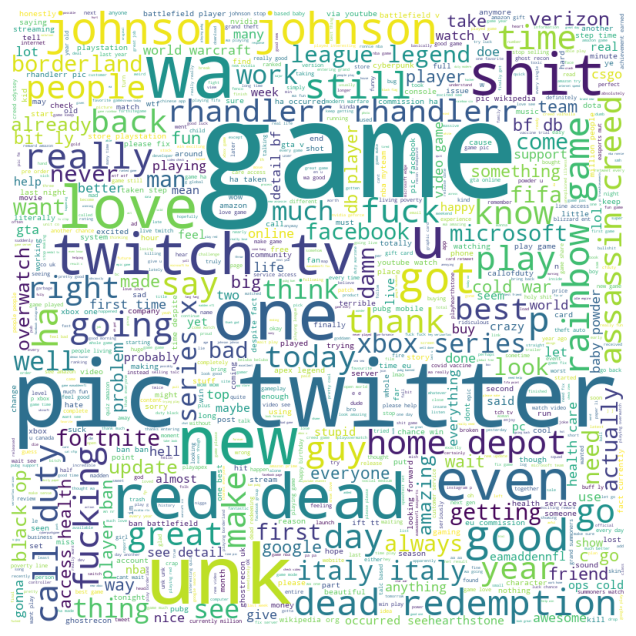

In [15]:
wordcloud = WordCloud(width = 800 , height = 800 , background_color = 'white', max_words = 1000).generate(words)

plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [16]:
# Extracting Top 1000 words

word = pd.Series(words.split()).value_counts()
word

game            11927
wa               5518
pic              4441
twitter          4390
one              3826
                ...  
youthful            1
sloggettin          1
ascent              1
brooch              1
battleroyale        1
Length: 27145, dtype: int64

In [17]:
frequent_words = list(word[0:10000].index)

In [18]:
df['Review'] = df['Review'].apply(lambda x : ' '.join([i for i in x.split() if i in frequent_words]))

In [19]:
# Encoding Target variable

df['Sentiment'].replace({'Positive':1 , 'Neutral':0 , 'Irrelevant':0 , 'Negative':-1} , inplace = True)

In [20]:
# Splitting the dataset randomly into train and test dataset using ratio of 70:30 

x = df['Review']
y = df['Sentiment']

xtrain , xtest , ytrain , ytest = train_test_split(x,y,test_size = 0.30 , random_state = 7)

In [21]:
# Intialising Tfidf and fitting into train dataset

vectorizer = TfidfVectorizer()

vectorizer.fit(xtrain)

TfidfVectorizer()

In [22]:
len(vectorizer.get_feature_names_out())

9984

In [23]:
# Transforming train and test dataset

tf_train = vectorizer.transform(xtrain)
tf_test = vectorizer.transform(xtest)

In [24]:
# Creating a dataframe for both train and test dataset

train_df = pd.DataFrame(tf_train.toarray() , columns = vectorizer.get_feature_names_out())
test_df = pd.DataFrame(tf_test.toarray() , columns = vectorizer.get_feature_names_out())

### Building different models and evaluating using appropriate technique

In [25]:
# Creating a user defined function to store values of accuracy , precision , recall , f1 score

performance_df = pd.DataFrame(columns = ['Model Name','Train Accuracy','Train Precision','Train Recall','Train f1_score',
                                            'Test Accuracy','Test Precision','Test Recall','Test f1_score'])

def model_performance(model,name,xtrain = xtrain,xtest = xtest):
    global performance_df
    
    # Predicting train and test data
   
    pred_train = model.predict(xtrain)
    pred_test = model.predict(xtest)
    
    # Calculating metrics for train and test data
    
    train_acc = round(accuracy_score(ytrain,pred_train),2)*100
    test_acc = round(accuracy_score(ytest,pred_test),2)*100
    train_precision = round(precision_score(ytrain,pred_train, average = 'macro'),2)
    test_precision = round(precision_score(ytest,pred_test, average = 'macro'),2)
    train_recall = round(recall_score(ytrain,pred_train, average = 'macro'),2)
    test_recall = round(recall_score(ytest,pred_test, average = 'macro'),2)
    train_f1 = round(f1_score(ytrain,pred_train, average = 'macro'),2)
    test_f1 = round(f1_score(ytest,pred_test, average = 'macro'),2)
    
        
    # Adding train and test scores in performance_df dataframe
    
    performance_df = performance_df.append({'Model Name': name, 'Train Accuracy':train_acc,
                                            'Train Precision': train_precision,
                                           'Train Recall': train_recall, 'Train f1_score':train_f1,
                                            'Test Accuracy':test_acc,'Test Precision':test_precision,
                                            'Test Recall':test_recall, 'Test f1_score': test_f1}, ignore_index = True)
    
    print('Train Report \n',classification_report(ytrain,pred_train),'\n')
    print('Test Report \n',classification_report(ytest,pred_test))

In [26]:
# Building Model using Logistic Regression

model_lr = LogisticRegression(multi_class='multinomial').fit(train_df,ytrain)

model_performance(model_lr, name = 'Logistic Regression' , xtrain = train_df , xtest = test_df)

Train Report 
               precision    recall  f1-score   support

          -1       0.85      0.82      0.83     15848
           0       0.80      0.87      0.84     22067
           1       0.83      0.76      0.79     14582

    accuracy                           0.82     52497
   macro avg       0.83      0.82      0.82     52497
weighted avg       0.82      0.82      0.82     52497
 

Test Report 
               precision    recall  f1-score   support

          -1       0.80      0.76      0.78      6776
           0       0.75      0.82      0.78      9373
           1       0.77      0.70      0.74      6350

    accuracy                           0.77     22499
   macro avg       0.77      0.76      0.77     22499
weighted avg       0.77      0.77      0.77     22499



In [27]:
# Building Model using Naive bayes

model_nb = MultinomialNB().fit(train_df,ytrain)

model_performance(model_nb , name = 'Naive Bayes' , xtrain = train_df , xtest = test_df)

Train Report 
               precision    recall  f1-score   support

          -1       0.79      0.78      0.79     15848
           0       0.76      0.84      0.80     22067
           1       0.80      0.69      0.74     14582

    accuracy                           0.78     52497
   macro avg       0.79      0.77      0.78     52497
weighted avg       0.78      0.78      0.78     52497
 

Test Report 
               precision    recall  f1-score   support

          -1       0.76      0.73      0.74      6776
           0       0.71      0.80      0.75      9373
           1       0.76      0.64      0.70      6350

    accuracy                           0.74     22499
   macro avg       0.74      0.73      0.73     22499
weighted avg       0.74      0.74      0.73     22499



In [28]:
# Building Model using DecisionTree

model_dt = DecisionTreeClassifier(max_depth=750,criterion='gini').fit(train_df,ytrain)

model_performance(model_dt, name = 'DecisionTree' , xtrain = train_df , xtest = test_df)

Train Report 
               precision    recall  f1-score   support

          -1       0.99      0.95      0.97     15848
           0       0.93      0.99      0.96     22067
           1       0.99      0.94      0.96     14582

    accuracy                           0.97     52497
   macro avg       0.97      0.96      0.97     52497
weighted avg       0.97      0.97      0.97     52497
 

Test Report 
               precision    recall  f1-score   support

          -1       0.84      0.80      0.82      6776
           0       0.79      0.86      0.83      9373
           1       0.83      0.77      0.80      6350

    accuracy                           0.82     22499
   macro avg       0.82      0.81      0.81     22499
weighted avg       0.82      0.82      0.82     22499



In [29]:
# Building Model using RandomForest

model_rf = RandomForestClassifier(max_depth=750,criterion='gini',n_estimators = 150,max_features = 50).fit(train_df,ytrain)

model_performance(model_rf , name = 'Random Forest' , xtrain = train_df , xtest = test_df)

Train Report 
               precision    recall  f1-score   support

          -1       0.99      0.96      0.98     15848
           0       0.94      0.99      0.97     22067
           1       0.99      0.95      0.97     14582

    accuracy                           0.97     52497
   macro avg       0.98      0.97      0.97     52497
weighted avg       0.97      0.97      0.97     52497
 

Test Report 
               precision    recall  f1-score   support

          -1       0.95      0.90      0.92      6776
           0       0.87      0.96      0.91      9373
           1       0.94      0.86      0.90      6350

    accuracy                           0.91     22499
   macro avg       0.92      0.91      0.91     22499
weighted avg       0.92      0.91      0.91     22499



In [31]:
performance_df

,Model Name,Train Accuracy,Train Precision,Train Recall,Train f1_score,Test Accuracy,Test Precision,Test Recall,Test f1_score
0,Logistic Regression,82.0,0.83,0.82,0.82,77.0,0.77,0.76,0.77
1,Naive Bayes,78.0,0.79,0.77,0.78,74.0,0.74,0.73,0.73
2,DecisionTree,97.0,0.97,0.96,0.97,82.0,0.82,0.81,0.81
3,Random Forest,97.0,0.98,0.97,0.97,91.0,0.92,0.91,0.91
